# Figure 2

In [1]:
%load_ext watermark
%watermark -a "Etienne Ackermann," -n -t -v -p nelpy,numpy,scipy,pandas,matplotlib

Etienne Ackermann, Tue Apr 17 2018 16:59:24 

CPython 3.5.4
IPython 6.2.1

nelpy 0.1.2
numpy 1.11.3
scipy 0.19.0
pandas 0.19.2
matplotlib 2.1.2


In [4]:
raise Exception('the data in this notebook appears to point to nonexistent data; it will be updated soon!')

Exception: the data in this notebook appears to point to nonexistent data; it will be updated soon!

In [3]:
import copy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import seaborn as sns
import time
import warnings

import scipy.ndimage.filters
import scipy.stats as stats

from IPython.display import display, clear_output

import nelpy as nel
import nelpy.plotting as npl
import nelpy.plotting.graph as npx
import nelpy.hmmutils

from sklearn.model_selection import train_test_split
from mpl_toolkits.axes_grid1 import make_axes_locatable

from nelpy.decoding import k_fold_cross_validation
from nelpy.decoding import decode1D

# Set default figure aesthetics
npl.setup(font_scale=1.0)

%matplotlib inline

warnings.filterwarnings("ignore")

In [4]:
datadirs = ['/home/etienne/Dropbox/neoReader/',
            'C:/Etienne/Dropbox/neoReader/',
            'D:/Dropbox/neoReader/']

fileroot = next( (dir for dir in datadirs if os.path.isdir(dir)), None)

if fileroot is None:
    raise FileNotFoundError('datadir not found')

load_from_nel = True

if load_from_nel:
    jar = nel.load_pkl(fileroot + 'gor01vvp01pin01_processed_speed_noIN.nel')
    exp_data = jar.exp_data
    aux_data = jar.aux_data
    del jar
    
    jar = nel.load_pkl(fileroot + 'gor01vvp01pin01_tables_speed_noIN.nel')
    df = jar.df
    df2 = jar.df2
    del jar


In [5]:
# restrict sessions to explore to a smaller subset
min_n_placecells = 20
min_n_PBEs = 30 # 27 total events ==> minimum 21 events in training set

df2_subset = df2[(df2.n_PBEs >= min_n_PBEs) & (df2.n_placecells >= min_n_placecells)]

sessions = df2_subset['time'].values.tolist()
segments = df2_subset['segment'].values.tolist()

print('Evaluating subset of {} sessions'.format(len(sessions)))

df2_subset.sort(columns=['n_PBEs', 'n_placecells'], ascending=[0,0])

Evaluating subset of 18 sessions


,animal,month,day,time,track,segment,duration,n_cells,n_placecells,n_PBEs,Notes,prescreen_z,n_cells_noIN,n_placecells_noIN
54,gor01,6,9,22-24-40,two,short,1620.0,203,61,301,NaN,NaN,186,61
1,gor01,6,7,16-40-19,two,short,1330.0,117,46,277,NaN,NaN,103,46
28,pin01,11,1,12-58-54,unknown,long,1670.0,49,21,238,NaN,NaN,48,21
29,pin01,11,1,12-58-54,unknown,short,925.0,49,26,222,NaN,NaN,48,26
0,gor01,6,7,16-40-19,two,long,1180.0,117,43,150,NaN,NaN,105,43
42,gor01,6,9,1-22-43,one,long,1012.0,203,62,117,NaN,NaN,184,62
53,gor01,6,9,22-24-40,two,long,912.0,203,66,103,NaN,NaN,185,66
43,gor01,6,9,1-22-43,one,short,617.0,203,71,91,NaN,NaN,185,71
18,gor01,6,8,21-16-25,two,long,720.0,171,82,57,NaN,NaN,155,82
60,vvp01,4,9,17-29-30,one,short,490.0,68,32,46,NaN,NaN,63,32


In [9]:
jar = nel.load_pkl(fileroot + 'sparsity_no_interneurons_all.nel')
sparsity = jar.aggregate
del jar

In [12]:
session, segment = '16-40-19', 'short'
hmms = sparsity[session, segment]['hmms']

In [13]:
npl.setup()

In [14]:
def figure_layout(fig):
    import matplotlib.gridspec as gridspec
    
    axes = []
    
    gs = gridspec.GridSpec(4, 1, height_ratios=[1, 1, 1, 1])
#     gs.update(left=0.05, right=0.95)

    gs0 = gridspec.GridSpecFromSubplotSpec(1, 6, subplot_spec=gs[0], wspace=0.1)
    gs1 = gridspec.GridSpecFromSubplotSpec(1, 6, subplot_spec=gs[1], wspace=0.1)
    gs2 = gridspec.GridSpecFromSubplotSpec(1, 6, subplot_spec=gs[2], wspace=0.1)
    gs3 = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[3], width_ratios=[0.2, 0.2, 0.2, 0.2], wspace=0.2)
    
    axes.append(fig.add_subplot(gs0[0]))
    axes.append(fig.add_subplot(gs0[1]))
    axes.append(fig.add_subplot(gs0[2]))
    axes.append(fig.add_subplot(gs0[3]))
    axes.append(fig.add_subplot(gs0[4]))
    axes.append(fig.add_subplot(gs0[5]))

    axes.append(fig.add_subplot(gs1[0]))
    axes.append(fig.add_subplot(gs1[1]))
    axes.append(fig.add_subplot(gs1[2]))
    axes.append(fig.add_subplot(gs1[3]))
    axes.append(fig.add_subplot(gs1[4]))
    axes.append(fig.add_subplot(gs1[5]))

    axes.append(fig.add_subplot(gs2[0]))
    axes.append(fig.add_subplot(gs2[1]))
    axes.append(fig.add_subplot(gs2[2]))
    axes.append(fig.add_subplot(gs2[3]))
    axes.append(fig.add_subplot(gs2[4]))
    axes.append(fig.add_subplot(gs2[5]))
    
    axes.append(fig.add_subplot(gs3[0]))
    axes.append(fig.add_subplot(gs3[1]))
    axes.append(fig.add_subplot(gs3[2]))
    axes.append(fig.add_subplot(gs3[3]))
            
    return axes

import numpy.linalg as LA

def spectral_gap(transmat):
    evals = LA.eigvals(transmat)
    sorder = np.argsort(np.abs(evals))
    gap = np.real(evals[sorder[-1]] - np.abs(evals[sorder[-2]]))
    return gap

class ColorBarLocator(object):
    def __init__(self, pax, pad=5, width=10):
        self.pax = pax
        self.pad = pad
        self.width = width

    def __call__(self, ax, renderer):
        x, y, w, h = self.pax.get_position().bounds
        fig = self.pax.get_figure()
        inv_trans = fig.transFigure.inverted()
        pad, _ = inv_trans.transform([self.pad, 0])
        width, _ = inv_trans.transform([self.width, 0])
        return [x+w+pad, y, width, h]

def plot_transmat(ax, hmm, edge_threshold=0.0, title='', cbar=True, ylabel=True, **fig_kws):
    cmap = fig_kws.get('cmap', plt.cm.viridis)
    
    num_states = hmm.hmm.n_components
    
    img = ax.matshow(np.where(hmm.hmm.transmat>edge_threshold, hmm.hmm.transmat, 0), cmap=cmap, vmin=0, vmax=1, interpolation='none', aspect='equal')
    ax.set_aspect('equal')
    
    if cbar:
        divider = make_axes_locatable(ax)
#         cax = divider.append_axes("right", size=0.1, pad=0.1)
        cax = fig.add_axes([0,0,0,0], axes_locator=ColorBarLocator(ax))
        cb=plt.colorbar(img, cax=cax)
        cb.set_label('probability', labelpad=-8)
        cb.set_ticks([0,1])
        npl.utils.no_ticks(cax)
        
#     if not cbar:
#         cax.set_visible(False)
    if ylabel:
        ax.set_yticks([0.5, num_states-1.5])
        ax.set_yticklabels(['1', str(num_states)])    
        ax.set_ylabel('state $i$', labelpad=-16)
    else:
        ax.set_yticks([])
        ax.set_yticklabels('')
    
    ax.set_xticks([0.5, num_states-1.5])
    ax.set_xticklabels(['1', str(num_states)])
    ax.set_xbound(lower=0.0, upper=num_states-1)
    ax.set_ybound(lower=0.0, upper=num_states-1)
    
    ax.set_xlabel('state $j$', labelpad=-16)
    
    ax.set_title(title + ' A')
    sns.despine(ax=ax)    
    
def plot_lambda(ax, hmm, cbar=True, ylabel=True, title='', lo=None, **fig_kws):
    cmap = fig_kws.get('cmap', plt.cm.viridis)
    
    num_states = hmm.hmm.n_components
    num_units = hmm.hmm.n_features
    
    if lo is not None:
        img = ax.matshow(hmm.hmm.means[:,lo].T, cmap=cmap, interpolation='none', aspect='auto')
    else:
        img = ax.matshow(hmm.hmm.means.T, cmap=cmap, interpolation='none', aspect='auto')
    
    if cbar:
        divider = make_axes_locatable(ax)
        cax = fig.add_axes([0,0,0,0], axes_locator=ColorBarLocator(ax))
        cax = divider.append_axes("right", size=0.1, pad=0.1)
        cb=plt.colorbar(img, cax=cax)
        cb.set_label('firing rate', labelpad=-8)
#         cb.set_ticks([0,1])
        cb.set_ticklabels(['lo', 'hi'])
        npl.utils.no_ticks(cax)
    
    if ylabel:
        ax.set_yticks([0.5, num_units-1.5])
        ax.set_yticklabels(['1', str(num_units)])
        ax.set_ylabel('unit', labelpad=-16)
    else:
        ax.set_yticks([])
        ax.set_yticklabels('')
        
    ax.set_xticks([0.5, num_states-1.5])
    ax.set_xticklabels(['1', str(num_states)])    
    
    ax.set_ybound(lower=0.0, upper=num_units-1)
    ax.set_xbound(lower=0.0, upper=num_states-1)
    
    ax.set_xlabel('state', labelpad=-16)
    ax.set_title(title + ' $\Lambda$')
    sns.despine(ax=ax)   
    ax.set_aspect(num_states/num_units)
    
def plot_sun_graph(ax, hmm, edge_threshold=0.0, lw=2, ec='k', nc='k', node_size=3, **fig_kws):
    plt.sca(ax)
    
    Gi = npx.inner_graph_from_transmat(hmm.hmm.transmat)
    Go = npx.outer_graph_from_transmat(hmm.hmm.transmat)
    
    npx.draw_transmat_graph_inner(Gi, edge_threshold=edge_threshold, lw=lw, ec=ec, node_size=node_size)
    npx.draw_transmat_graph_outer(Go, Gi, edge_threshold=edge_threshold, lw=lw, ec=ec, nc=nc, node_size=node_size*2)

    ax.set_xlim(-1.4,1.4)
    ax.set_ylim(-1.4,1.4)
#     ax0, img = npl.imagesc(hmm.transmat, ax=axes[0])
    npl.utils.clear_left_right(ax)
    npl.utils.clear_top_bottom(ax)
    
#     ax.set_title('1 - $|\lambda_2| =$ {0:.2f}'.format(float(spectral_gap(hmm.hmm.transmat))))
    ax.set_title('$\gamma^*=$ {0:.3f}'.format(float(spectral_gap(hmm.hmm.transmat))), y=1.02)
    
    ax.set_aspect('equal')
    
def plot_connectivity_graph(ax, hmm, edge_threshold=0.0, lw=2, ec='k', node_size=3, **fig_kws):
    plt.sca(ax)
    
    G = npx.graph_from_transmat(hmm.hmm.transmat)
    
    npx.draw_transmat_graph(G, edge_threshold=edge_threshold, lw=lw, ec=ec, node_size=node_size)
#     ax.set_xlim(-1.3,1.3)
#     ax.set_ylim(-1.3,1.3)
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
#     ax0, img = npl.imagesc(hmm.transmat, ax=axes[0])
    npl.utils.clear_left_right(ax)
    npl.utils.clear_top_bottom(ax)
    ax1.set_aspect('equal')
    
def plot_transmat_gini_departure(ax, hmms, n_max=500, **fig_kws):
    
    hist_kws={"range": (0.8, 1)}
    bins=50

    for hmm in hmms:
        data = np.array(hmm.results['gini_tmat_departure'])
        data = data[:n_max,:]
        sns.distplot(data.sum(axis=0)/len(data), hist=False, hist_kws=hist_kws, bins=bins, label=hmm.label, ax=ax)

    ax.set_title('tmat gini departure, N=250')
    
    ax.set_xlim(0.7, 1)
    
    sns.despine(ax=ax)
    
def plot_transmat_gini_arrival(ax, hmms, n_max=500, **fig_kws):
    
    hist_kws={"range": (0.8, 1)}
    bins=50

    for hmm in hmms:
        data = np.array(hmm.results['gini_tmat_arrival'])
        data = data[:n_max,:]
        sns.distplot(data.sum(axis=0)/len(data), hist=False, hist_kws=hist_kws, bins=bins, label=hmm.label, ax=ax)

    ax.set_title('tmat gini arrival, N=250')
    ax.legend('')
    ax.set_xlim(0.7, 1)
    
    sns.despine(ax=ax)
    
def plot_bottleneck(ax, hmms, n_max=500, **fig_kws):
    
    hist_kws={"range": (0, 0.5)}
    bins=50

    for hmm in hmms:
        data = np.array(hmm.results['bottleneck'])
        data = data[:n_max]
        sns.distplot(data, hist=False, hist_kws=hist_kws, bins=bins, label=hmm.label, ax=ax)

    ax.set_title('bottleneck, N=250')
    
    ax.legend('')
    
    ax.set_xlim(0, 0.5)
    
    sns.despine(ax=ax)
    
def plot_gini_lambda(ax, hmms, n_max=500, **fig_kws):
    
    hist_kws={"range": (0.3, 1.0)}
    bins=50

    for hmm in hmms:
        data = np.array(hmm.results['gini_lambda'])
        data = data[:n_max]
        sns.distplot(data, hist=False, hist_kws=hist_kws, bins=bins, label=hmm.label, ax=ax)

    ax.set_title('lambda gini, N=250')
    ax.legend('')
    ax.set_xlim(0.3, 1.0)
    
    sns.despine(ax=ax)
    


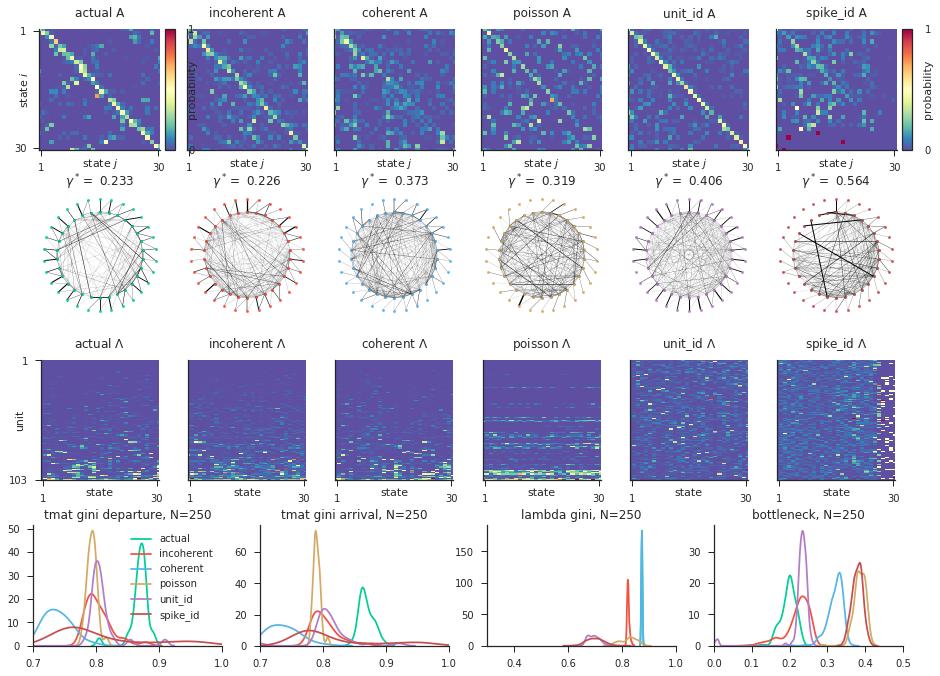

In [15]:
fig = plt.figure(1, figsize=(13, 10))
# fig = plt.figure(1, figsize=(16, 14))

lambda_order = np.argsort(hmms[0].hmm.means.sum(axis=0))

## define the figure layout
axes = figure_layout(fig)

## define figure parameters and color pallete
text_kws = dict(ha="center", size=7)
fig_kws = dict(text_kws=text_kws, cmap=plt.cm.Spectral_r)

# ## plot the various panels
plot_transmat(axes[0], hmm=hmms[0], title=hmms[0].label, cbar=True, **fig_kws)
plot_transmat(axes[1], hmm=hmms[1], title=hmms[1].label, cbar=False, ylabel=False, **fig_kws)
plot_transmat(axes[2], hmm=hmms[2], title=hmms[2].label, cbar=False, ylabel=False, **fig_kws)
plot_transmat(axes[3], hmm=hmms[3], title=hmms[3].label, cbar=False, ylabel=False, **fig_kws)
plot_transmat(axes[4], hmm=hmms[4], title=hmms[4].label, cbar=False, ylabel=False, **fig_kws)
plot_transmat(axes[5], hmm=hmms[5], title=hmms[5].label, cbar=True, ylabel=False, **fig_kws)

plot_sun_graph(axes[6], hmm=hmms[0], nc=npl.colors.sweet.green, **fig_kws)
plot_sun_graph(axes[7], hmm=hmms[1], nc=npl.colors.sweet.red, **fig_kws)
plot_sun_graph(axes[8], hmm=hmms[2], nc=npl.colors.sweet.blue, **fig_kws)
plot_sun_graph(axes[9], hmm=hmms[3], nc=npl.colors.sweet.gold, **fig_kws)
plot_sun_graph(axes[10], hmm=hmms[4], nc=npl.colors.sweet.purple, **fig_kws)
plot_sun_graph(axes[11], hmm=hmms[5], nc=npl.colors.sweet.maroon, **fig_kws)

plot_lambda(axes[12], hmm=hmms[0], title=hmms[0].label, lo=lambda_order,cbar=False,**fig_kws)
plot_lambda(axes[13], hmm=hmms[1], title=hmms[1].label, lo=lambda_order,ylabel=False, cbar=False,**fig_kws)
plot_lambda(axes[14], hmm=hmms[2], title=hmms[2].label, lo=lambda_order,ylabel=False, cbar=False,**fig_kws)
plot_lambda(axes[15], hmm=hmms[3], title=hmms[3].label, lo=lambda_order,ylabel=False, cbar=False,**fig_kws)
plot_lambda(axes[16], hmm=hmms[4], title=hmms[4].label, lo=lambda_order,ylabel=False, cbar=False, **fig_kws)
plot_lambda(axes[17], hmm=hmms[5], title=hmms[5].label, lo=lambda_order,ylabel=False, cbar=False, **fig_kws)

plot_transmat_gini_departure(axes[18], hmms, **fig_kws)
plot_transmat_gini_arrival(axes[19], hmms, **fig_kws)
plot_gini_lambda(axes[20], hmms, **fig_kws)
plot_bottleneck(axes[21], hmms, **fig_kws)

fig.tight_layout(h_pad=.5, w_pad=0.75, rect=[0, .05, 1, 1])

# Box and whiskers replacements for Figure 2 D, E, F

In [21]:
import pandas as pd

hmms = sparsity[session, segment]['hmms']

labels = [hmm.label for hmm in hmms][:4]
labels

['actual', 'incoherent', 'coherent', 'poisson']

# Figure 2.c

Ttest_indResult(statistic=85.744477284862299, pvalue=6.589775343997467e-282)
Ttest_indResult(statistic=165.52776005568134, pvalue=0.0)
Ttest_indResult(statistic=63.126480048943236, pvalue=1.5396300790667765e-184)


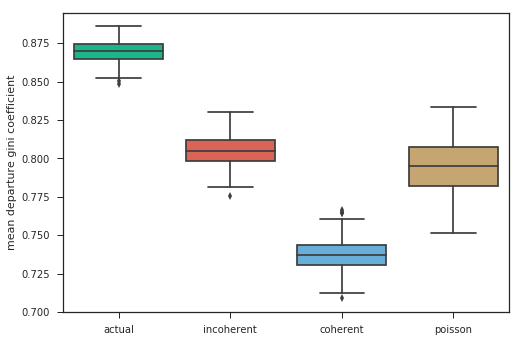

In [22]:
gini_departure = pd.DataFrame(np.array((np.array(hmms[0].results['gini_tmat_departure']),
             np.array(hmms[1].results['gini_tmat_departure']),
             np.array(hmms[2].results['gini_tmat_departure']),
             np.array(hmms[3].results['gini_tmat_departure']),
#              np.array(hmms[4].results['gini_tmat_departure']),
#              np.array(hmms[5].results['gini_tmat_departure']),
             )).mean(axis=-1).T, columns=labels)

sns.boxplot(data=gini_departure)
plt.ylabel('mean departure gini coefficient')

actual = np.array(hmms[0].results['gini_tmat_departure']).mean(axis=1)
incoherent = np.array(hmms[1].results['gini_tmat_departure']).mean(axis=1)
coherent = np.array(hmms[2].results['gini_tmat_departure']).mean(axis=1)
poisson = np.array(hmms[3].results['gini_tmat_departure']).mean(axis=1)

# significant?
print(stats.ttest_ind(actual, incoherent, equal_var=False))
print(stats.ttest_ind(actual, coherent, equal_var=False))
print(stats.ttest_ind(actual, poisson, equal_var=False))

# Figure 2.d

Ttest_indResult(statistic=143.02901186112734, pvalue=0.0)
Ttest_indResult(statistic=4.5246245748540783, pvalue=7.5787340810421698e-06)
Ttest_indResult(statistic=63.329401727776656, pvalue=8.2100401705210687e-156)


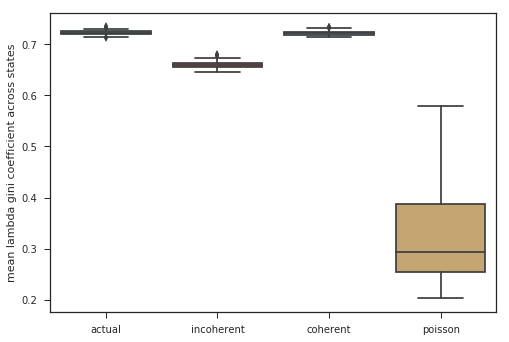

In [23]:
sns.boxplot(data=pd.DataFrame(np.array((np.array(hmms[0].results['gini_lambda_across_states']).mean(axis=1),
             np.array(hmms[1].results['gini_lambda_across_states']).mean(axis=1),
             np.array(hmms[2].results['gini_lambda_across_states']).mean(axis=1),
             np.array(hmms[3].results['gini_lambda_across_states']).mean(axis=1),
#              np.array(hmms[4].results['gini_lambda_across_states']).mean(axis=1),
#              np.array(hmms[5].results['gini_lambda_across_states']).mean(axis=1),
             )).T, columns=labels))
plt.ylabel('mean lambda gini coefficient across states')

actual = np.array(hmms[0].results['gini_lambda_across_states']).mean(axis=1)
incoherent = np.array(hmms[1].results['gini_lambda_across_states']).mean(axis=1)
coherent = np.array(hmms[2].results['gini_lambda_across_states']).mean(axis=1)
poisson = np.array(hmms[3].results['gini_lambda_across_states']).mean(axis=1)

# significant?
print(stats.ttest_ind(actual, incoherent, equal_var=False))
print(stats.ttest_ind(actual, coherent, equal_var=False))
print(stats.ttest_ind(actual, poisson, equal_var=False))

## Pool results over all 18 sessions

In [24]:
gini_departure_all_18 = pd.DataFrame()
bottleneck_all_18 = pd.DataFrame()
lambda_gini_all_18 = pd.DataFrame()

for session, segment in zip(sessions, segments):
    
    hmms = sparsity[session, segment]['hmms']
    
    gini_departure = pd.DataFrame(np.array((np.array(hmms[0].results['gini_tmat_departure']),
             np.array(hmms[1].results['gini_tmat_departure']),
             np.array(hmms[2].results['gini_tmat_departure']),
             np.array(hmms[3].results['gini_tmat_departure']),
#              np.array(hmms[4].results['gini_tmat_departure']),
#              np.array(hmms[5].results['gini_tmat_departure']),
             )).mean(axis=-1).T, columns=labels)
    
    bottleneck = pd.DataFrame(np.array((
             np.where(np.array(hmms[0].results['bottleneck'])>0,np.array(hmms[0].results['bottleneck']),0),
             np.where(np.array(hmms[1].results['bottleneck'])>0,np.array(hmms[1].results['bottleneck']),0),
             np.where(np.array(hmms[2].results['bottleneck'])>0,np.array(hmms[2].results['bottleneck']),0),
             np.where(np.array(hmms[3].results['bottleneck'])>0,np.array(hmms[3].results['bottleneck']),0),
#              np.where(np.array(hmms[4].results['bottleneck'])>0,np.array(hmms[4].results['bottleneck']),0),
#              np.where(np.array(hmms[5].results['bottleneck'])>0,np.array(hmms[5].results['bottleneck']),0),
             )).T, columns=labels)
    
    lambda_gini = pd.DataFrame(np.array((np.array(hmms[0].results['gini_lambda_across_states']).mean(axis=1),
             np.array(hmms[1].results['gini_lambda_across_states']).mean(axis=1),
             np.array(hmms[2].results['gini_lambda_across_states']).mean(axis=1),
             np.array(hmms[3].results['gini_lambda_across_states']).mean(axis=1),
#              np.array(hmms[4].results['gini_lambda_across_states']).mean(axis=1),
#              np.array(hmms[5].results['gini_lambda_across_states']).mean(axis=1),
             )).T, columns=labels)
    
    gini_departure_all_18 = gini_departure_all_18.append(gini_departure.mean(axis=0), ignore_index=True)
    bottleneck_all_18 = bottleneck_all_18.append(bottleneck.mean(axis=0), ignore_index=True)
    lambda_gini_all_18 = lambda_gini_all_18.append(lambda_gini.mean(axis=0), ignore_index=True)
    

In [25]:
bottleneck_all_18

,actual,coherent,incoherent,poisson
0,0.179937,0.280299,0.200701,0.380955
1,0.197022,0.320679,0.221347,0.385928
2,0.197237,0.245404,0.177855,0.318908
3,0.158797,0.190577,0.121335,0.359976
4,0.060832,0.209054,0.219062,0.270281
5,0.073802,0.162219,0.164504,0.271977
6,0.053695,0.261815,0.255760,0.293813
7,0.027102,0.067924,0.065802,0.200132
8,0.192088,0.284003,0.191261,0.357105
9,0.185311,0.215434,0.161501,0.358619


In [26]:
print(stats.wilcoxon(gini_departure_all_18.actual, gini_departure_all_18.incoherent))
print(stats.wilcoxon(gini_departure_all_18.actual, gini_departure_all_18.coherent))
print(stats.wilcoxon(gini_departure_all_18.actual, gini_departure_all_18.poisson))
print('\n')

print(stats.wilcoxon(bottleneck_all_18.actual, bottleneck_all_18.incoherent))
print(stats.wilcoxon(bottleneck_all_18.actual, bottleneck_all_18.coherent))
print(stats.wilcoxon(bottleneck_all_18.actual, bottleneck_all_18.poisson))
print('\n')

print(stats.wilcoxon(lambda_gini_all_18.actual, lambda_gini_all_18.incoherent))
print(stats.wilcoxon(lambda_gini_all_18.actual, lambda_gini_all_18.coherent))
print(stats.wilcoxon(lambda_gini_all_18.actual, lambda_gini_all_18.poisson))


WilcoxonResult(statistic=0.0, pvalue=0.00019643672621231134)
WilcoxonResult(statistic=0.0, pvalue=0.00019643672621231134)
WilcoxonResult(statistic=7.0, pvalue=0.00062920383081132593)


WilcoxonResult(statistic=65.0, pvalue=0.37197377196466852)
WilcoxonResult(statistic=0.0, pvalue=0.00019643672621231134)
WilcoxonResult(statistic=0.0, pvalue=0.00019643672621231134)


WilcoxonResult(statistic=7.0, pvalue=0.00062920383081132593)
WilcoxonResult(statistic=30.0, pvalue=0.015647093863347505)
WilcoxonResult(statistic=0.0, pvalue=0.00019643672621231134)


# Figure 2.e

(0.6, 1)

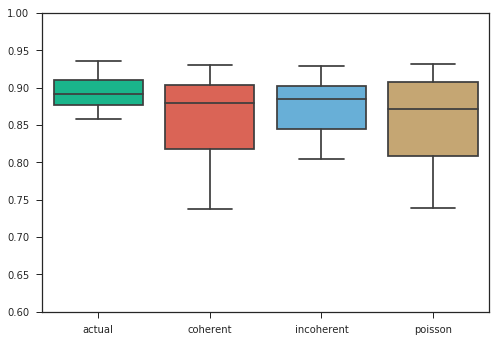

In [27]:
sns.boxplot(data=gini_departure_all_18)
plt.ylim(0.6, 1)

# Figure 2.f

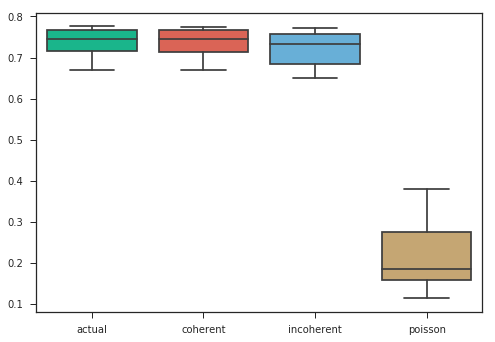

In [29]:
sns.boxplot(data=lambda_gini_all_18)